## 1. Preparing our dataset
<p><em>These recommendations are so on point! How does this playlist know me so well?</em></p>
<p><img src="https://assets.datacamp.com/production/project_449/img/iphone_music.jpg" alt="Project Image Record" width="600px"></p>
<p>Over the past few years, streaming services with huge catalogs have become the primary means through which most people listen to their favorite music. But at the same time, the sheer amount of music on offer can mean users might be a bit overwhelmed when trying to look for newer music that suits their tastes.</p>
<p>For this reason, streaming services have looked into means of categorizing music to allow for personalized recommendations. One method involves direct analysis of the raw audio information in a given song, scoring the raw data on a variety of metrics. Today, we'll be examining data compiled by a research group known as The Echo Nest. Our goal is to look through this dataset and classify songs as being either 'Hip-Hop' or 'Rock' - all without listening to a single one ourselves. In doing so, we will learn how to clean our data, do some exploratory data visualization, and use feature reduction towards the goal of feeding our data through some simple machine learning algorithms, such as decision trees and logistic regression.</p>
<p>To begin with, let's load the metadata about our tracks alongside the track metrics compiled by The Echo Nest. A song is about more than its title, artist, and number of listens. We have another dataset that has musical features of each track such as <code>danceability</code> and <code>acousticness</code> on a scale from -1 to 1. These exist in two different files, which are in different formats - CSV and JSON. While CSV is a popular file format for denoting tabular data, JSON is another common file format in which databases often return the results of a given query.</p>
<p>Let's start by creating two pandas <code>DataFrames</code> out of these files that we can merge so we have features and labels (often also referred to as <code>X</code> and <code>y</code>) for the classification later on.</p>

Classifying song genres from audio data is a challenging but fascinating project that involves machine learning, audio signal processing, and data analysis

In [753]:
import pandas as pd

# Step 1: Read in the track metadata using read_csv()
tracks = pd.read_csv('datasets/fma-rock-vs-hiphop.csv')

# Step 2: Read in the JSON file with track acoustic metrics using read_json()
echonest_metrics = pd.read_json('datasets/echonest-metrics.json', precise_float=True)

# Step 3: Merge the DataFrames on matching track_id values, retaining only the desired columns
echo_tracks = pd.merge(echonest_metrics, tracks[['track_id', 'genre_top']], on='track_id')

# Step 4: Inspect the resulting DataFrame using the .info() method
echo_tracks.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
acousticness        4802 non-null float64
danceability        4802 non-null float64
energy              4802 non-null float64
instrumentalness    4802 non-null float64
liveness            4802 non-null float64
speechiness         4802 non-null float64
tempo               4802 non-null float64
track_id            4802 non-null int64
valence             4802 non-null float64
genre_top           4802 non-null object
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


- I first import the pandas library.
- I read the track metadata from a CSV file into the tracks DataFrame using pd.read_csv().
- I read the track acoustic metrics from a JSON file into the echonest_metrics DataFrame using pd.read_json() and set precise_float=True to ensure proper precision when reading float values.
- We merge the two DataFrames on the 'track_id' column using pd.merge(). We specify that echonest_metrics should be the first (left) DataFrame in the merge and only retain the 'track_id' and 'genre_top' columns from the tracks DataFrame.
- Finally, we inspect the resulting DataFrame merged_data using the .info() method to get information about the DataFrame's structure and data types.
- This code will give you information about the merged DataFrame, including the number of non-null values in each column and the data types of each column.

## 2. Pairwise relationships between continuous variables
<p>We typically want to avoid using variables that have strong correlations with each other -- hence avoiding feature redundancy -- for a few reasons:</p>
<ul>
<li>To keep the model simple and improve interpretability (with many features, we run the risk of overfitting).</li>
<li>When our datasets are very large, using fewer features can drastically speed up our computation time.</li>
</ul>
<p>To get a sense of whether there are any strongly correlated features in our data, we will use built-in functions in the <code>pandas</code> package.</p>

In [755]:

# Create a correlation matrix
corr_metrics = echo_tracks.corr()

# Visualize the correlation matrix with a gradient background
corr_metrics.style.background_gradient()


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,track_id,valence
acousticness,1,-0.0289537,-0.281619,0.19478,-0.0199914,0.072204,-0.0263097,-0.372282,-0.0138406
danceability,-0.0289537,1,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.0494541,0.473165
energy,-0.281619,-0.242032,1,0.0282377,0.113331,-0.109983,0.195227,0.140703,0.0386027
instrumentalness,0.19478,-0.255217,0.0282377,1,-0.0910218,-0.366762,0.022215,-0.275623,-0.219967
liveness,-0.0199914,-0.106584,0.113331,-0.0910218,1,0.0411725,0.00273169,0.0482307,-0.0450931
speechiness,0.072204,0.276206,-0.109983,-0.366762,0.0411725,1,0.00824055,-0.0269951,0.149894
tempo,-0.0263097,-0.242089,0.195227,0.022215,0.00273169,0.00824055,1,-0.0253918,0.0522212
track_id,-0.372282,0.0494541,0.140703,-0.275623,0.0482307,-0.0269951,-0.0253918,1,0.0100698
valence,-0.0138406,0.473165,0.0386027,-0.219967,-0.0450931,0.149894,0.0522212,0.0100698,1


- "Danceability" and "valence" have a relatively strong positive correlation (0.473165), indicating that songs that are more danceable tend to have a higher valence (positive emotional content).
- "Acousticness" has a negative correlation with several other metrics, such as "energy" (-0.281619) and "tempo" (-0.0263097). This suggests that acoustic songs (higher acousticness) tend to have lower energy and slower tempos.
- "Instrumentalness" has a negative correlation with "danceability" (-0.255217) and "speechiness" (-0.366762), suggesting that instrumental tracks are less danceable and contain less speech.
- "Energy" and "valence" have positive correlations with "speechiness," indicating that energetic and emotionally positive songs may contain more speech.
- "Liveness" doesn't show strong correlations with most other metrics, except a weak positive correlation with "danceability" (0.0411725).

## 3. Splitting our data
<p>As mentioned earlier, it can be particularly useful to simplify our models and use as few features as necessary to achieve the best result. Since we didn't find any particularly strong correlations between our features, we can now split our data into an array containing our features, and another containing the labels - the genre of the track. </p>
<p>Once we have split the data into these arrays, we will perform some preprocessing steps to optimize our model development.</p>

In [757]:
from sklearn.model_selection import train_test_split

# Create features by excluding "genre_top" and "track_id" columns
features = echo_tracks.drop(columns=["genre_top", "track_id"]).values

# Create labels as an array of the "genre_top" column
labels = echo_tracks["genre_top"].values

# Split the data into train and test sets
# Use random_state for reproducibility
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=10)

# Print the shapes for verification
print("Train Features Shape:", train_features.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Features Shape:", test_features.shape)
print("Test Labels Shape:", test_labels.shape)

Train Features Shape: (3601, 8)
Train Labels Shape: (3601,)
Test Features Shape: (1201, 8)
Test Labels Shape: (1201,)


## 4. Normalizing the feature data
<p>As mentioned earlier, it can be particularly useful to simplify our models and use as few features as necessary to achieve the best result. Since we didn't find any particular strong correlations between our features, we can instead use a common approach to reduce the number of features called <strong>principal component analysis (PCA)</strong>. </p>
<p>It is possible that the variance between genres can be explained by just a few features in the dataset. PCA rotates the data along the axis of highest variance, thus allowing us to determine the relative contribution of each feature of our data towards the variance between classes. </p>
<p>However, since PCA uses the absolute variance of a feature to rotate the data, a feature with a broader range of values will overpower and bias the algorithm relative to the other features. To avoid this, we must first normalize our train and test features. There are a few methods to do this, but a common way is through <em>standardization</em>, such that all features have a mean = 0 and standard deviation = 1 (the resultant is a z-score). </p>

The code prepares your data for machine learning by splitting it into features (input data) and labels (target variable), and then further splits it into training and test sets for model training and evaluation. This is a fundamental step in preparing data for machine learning tasks.

In [759]:
from sklearn.preprocessing import StandardScaler


# Define an instance of the StandardScaler
scaler = StandardScaler()

# Fit and transform the training features
scaled_train_features = scaler.fit_transform(train_features)

# Transform the test features using the same scaler
scaled_test_features = scaler.transform(test_features)


Finally, the train_test_split function to split your data into training and test sets. Here's what each variable represents after this line:

train_features: This is the portion of your features data that will be used for training your machine learning model.
test_features: This is the portion of your features data that will be used for testing the model's performance.
train_labels: These are the corresponding labels for the training features. They represent the expected outcomes during model training.
test_labels: These are the corresponding labels for the test features. You will use them to evaluate how well your trained model performs on unseen data.

## 5. Principal Component Analysis on our scaled data
<p>Now that we have preprocessed our data, we are ready to use PCA to determine by how much we can reduce the dimensionality of our data. We can use <strong>scree-plots</strong> and <strong>cumulative explained ratio plots</strong> to find the number of components to use in further analyses.</p>
<p>Scree-plots display the number of components against the variance explained by each component, sorted in descending order of variance. Scree-plots help us get a better sense of which components explain a sufficient amount of variance in our data. When using scree plots, an 'elbow' (a steep drop from one data point to the next) in the plot is typically used to decide on an appropriate cutoff.</p>

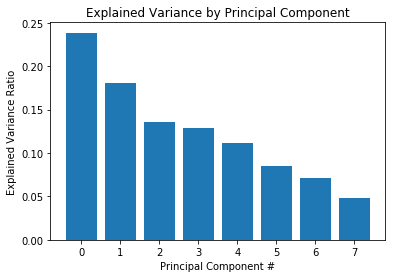

In [761]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize the PCA model
pca = PCA()

# Fit the PCA model to the scaled training features
pca.fit(scaled_train_features)

# Get the explained variance ratio
exp_variance = pca.explained_variance_ratio_

exp_variance

# Create a barplot to visualize explained variance
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')
ax.set_ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Component')
plt.show()

## 6. Further visualization of PCA
<p>Unfortunately, there does not appear to be a clear elbow in this scree plot, which means it is not straightforward to find the number of intrinsic dimensions using this method. </p>
<p>But all is not lost! Instead, we can also look at the <strong>cumulative explained variance plot</strong> to determine how many features are required to explain, say, about 85% of the variance (cutoffs are somewhat arbitrary here, and usually decided upon by 'rules of thumb'). Once we determine the appropriate number of components, we can perform PCA with that many components, ideally reducing the dimensionality of our data.</p>

np.cumsum(exp_variance) represents the cumulative explained variance. Each element in this array represents the cumulative proportion of variance explained by including all principal components up to that point.

You can think of it as the accumulation of explained variance as you include more and more principal components. It is often used to determine how many principal components are needed to retain a certain percentage of the total variance in the data.

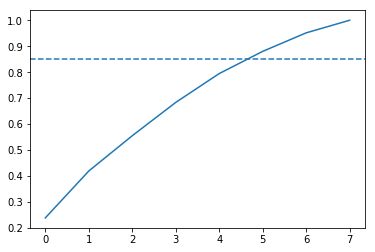

In [763]:
# Import numpy
import numpy as np
# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)
cum_exp_variance

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')


## 7. Projecting on to our features
<p>We saw from the plot that 6 features (remember indexing starts at 0) can explain 85% of the variance! </p>
<p>Therefore, we can use 6 components to perform PCA and reduce the dimensionality of our train and test features.</p>

In [765]:
from sklearn.decomposition import PCA

# Create PCA with n_components=6 and random_state=10
pca = PCA(n_components=6, random_state=10)

# Fit and transform the training features
train_pca = pca.fit_transform(scaled_train_features)

# Transform the test features using the same PCA
test_pca = pca.transform(scaled_test_features)




1. **Import PCA**: The line `from sklearn.decomposition import PCA` imports the PCA class from scikit-learn, which is a library for machine learning in Python.

2. **Create PCA Object**: You create a PCA object named `pca` with two specific parameters:
   - `n_components=6`: This parameter specifies the number of principal components you want to keep after dimensionality reduction. In this case, you want to keep 6 principal components.
   - `random_state=10`: This parameter sets a random seed for reproducibility. It ensures that the same results will be obtained each time you run the code.

3. **Fit and Transform Training Features**: The `fit_transform` method is applied to the training features (`scaled_train_features`). This method fits the PCA model to the training data and then transforms the training features into a new set of features that are represented in terms of the selected principal components. This reduces the dimensionality of the training data to 6 principal components.

4. **Transform Test Features**: The `transform` method is applied to the test features (`scaled_test_features`). It uses the same PCA model that was fitted to the training data to transform the test features into the same reduced feature space, ensuring that the same dimensionality reduction is applied consistently to both the training and test data.

The result is that `train_pca` and `test_pca` now contain the training and test data, respectively, but represented in a lower-dimensional space defined by the first 6 principal components. This dimensionality reduction can be useful for various purposes, such as improving the efficiency of machine learning algorithms or visualizing data in lower dimensions.

## 8. Train a decision tree to classify genre
<p>Now we can use the lower dimensional PCA projection of the data to classify songs into genres. </p>
<p>Here, we will be using a simple algorithm known as a decision tree. Decision trees are rule-based classifiers that take in features and follow a 'tree structure' of binary decisions to ultimately classify a data point into one of two or more categories. In addition to being easy to both use and interpret, decision trees allow us to visualize the 'logic flowchart' that the model generates from the training data.</p>
<p>Here is an example of a decision tree that demonstrates the process by which an input image (in this case, of a shape) might be classified based on the number of sides it has and whether it is rotated.</p>
<p><img src="https://assets.datacamp.com/production/project_449/img/simple_decision_tree.png" alt="Decision Tree Flow Chart Example" width="350px"></p>

In [767]:
# Import Decision tree classifier
from sklearn.tree import DecisionTreeClassifier

# Create our decision tree
tree = DecisionTreeClassifier(random_state=10)

# Train our decision tree
tree.fit(train_pca, train_labels)

# Predict the labels for the test data
pred_labels_tree = tree.predict(test_pca)



1. **Import Decision Tree Classifier**: It imports the `DecisionTreeClassifier` class from scikit-learn, which is a popular library for machine learning in Python.

2. **Create Decision Tree**: A Decision Tree Classifier is created with the name `tree`. The `random_state` parameter is set to 10 for reproducibility, ensuring that the same results are obtained when running the code multiple times.

3. **Train Decision Tree**: The `fit` method is used to train the Decision Tree model. It takes two arguments:
   - `train_pca`: This is the training data after PCA (Principal Component Analysis) transformation. It contains the lower-dimensional representation of the features obtained from the training dataset.
   - `train_labels`: These are the corresponding labels for the training data, which represent the target variable.

4. **Predict Labels**: After training, the Decision Tree model is used to make predictions on the test data, which is represented in the lower-dimensional space (`test_pca`). The predicted labels are stored in the `pred_labels_tree` variable.

In summary, this code trains a Decision Tree Classifier on the reduced-dimensional training data obtained through PCA and then uses the trained model to predict the labels for the test data. This is a common workflow in machine learning for supervised classification tasks.

## 9. Compare our decision tree to a logistic regression
<p>Although our tree's performance is decent, it's a bad idea to immediately assume that it's therefore the perfect tool for this job -- there's always the possibility of other models that will perform even better! It's always a worthwhile idea to at least test a few other algorithms and find the one that's best for our data.</p>
<p>Sometimes simplest is best, and so we will start by applying <strong>logistic regression</strong>. Logistic regression makes use of what's called the logistic function to calculate the odds that a given data point belongs to a given class. Once we have both models, we can compare them on a few performance metrics, such as false positive and false negative rate (or how many points are inaccurately classified). </p>

In [769]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train our logistic regression and predict labels for the test set
logreg = LogisticRegression(random_state = 10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
              precision    recall  f1-score   support

    Hip-Hop       0.70      0.70      0.70       229
       Rock       0.93      0.93      0.93       972

avg / total       0.88      0.88      0.88      1201

Logistic Regression: 
              precision    recall  f1-score   support

    Hip-Hop       0.78      0.58      0.67       229
       Rock       0.91      0.96      0.93       972

avg / total       0.88      0.89      0.88      1201





**Decision Tree Classifier:**
- Precision for Hip-Hop (0.70): This means that when the Decision Tree predicts a track as "Hip-Hop," it is correct 70% of the time.
- Recall for Hip-Hop (0.70): Out of all actual "Hip-Hop" tracks, the model correctly identifies 70% of them.
- F1-score for Hip-Hop (0.70): The F1-score is the harmonic mean of precision and recall, providing a balance between the two. For "Hip-Hop," it's 0.70.
- Precision for Rock (0.93): When the model predicts a track as "Rock," it is correct 93% of the time.
- Recall for Rock (0.93): Out of all actual "Rock" tracks, the model correctly identifies 93% of them.
- F1-score for Rock (0.93): The F1-score for "Rock" is 0.93, indicating a strong balance between precision and recall.
- Support: The number of samples in each class (Hip-Hop and Rock).

**Logistic Regression:**
- Precision for Hip-Hop (0.78): The Logistic Regression model's precision for "Hip-Hop" is 78%.
- Recall for Hip-Hop (0.58): Out of all actual "Hip-Hop" tracks, the model correctly identifies 58% of them.
- F1-score for Hip-Hop (0.67): The F1-score for "Hip-Hop" is 0.67, indicating a moderate balance between precision and recall.
- Precision for Rock (0.91): When the model predicts a track as "Rock," it is correct 91% of the time.
- Recall for Rock (0.96): Out of all actual "Rock" tracks, the model correctly identifies 96% of them.
- F1-score for Rock (0.93): The F1-score for "Rock" is 0.93, indicating a strong balance between precision and recall.
- Support: The number of samples in each class (Hip-Hop and Rock).

In summary:
- The Decision Tree model has good overall performance, with balanced precision and recall for both classes.
- The Logistic Regression model has higher precision for "Hip-Hop" but lower recall, while it performs exceptionally well for "Rock" in terms of both precision and recall.


## 10. Balance our data for greater performance
<p>Both our models do similarly well, boasting an average precision of 87% each. However, looking at our classification report, we can see that rock songs are fairly well classified, but hip-hop songs are disproportionately misclassified as rock songs. </p>
<p>Why might this be the case? Well, just by looking at the number of data points we have for each class, we see that we have far more data points for the rock classification than for hip-hop, potentially skewing our model's ability to distinguish between classes. This also tells us that most of our model's accuracy is driven by its ability to classify just rock songs, which is less than ideal.</p>
<p>To account for this, we can weight the value of a correct classification in each class inversely to the occurrence of data points for each class. Since a correct classification for "Rock" is not more important than a correct classification for "Hip-Hop" (and vice versa), we only need to account for differences in <em>sample size</em> of our data points when weighting our classes here, and not relative importance of each class. </p>

In [771]:
# Subset a balanced proportion of data points
hop_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Hip-Hop']
rock_only = echo_tracks.loc[echo_tracks['genre_top'] == 'Rock']

# subset only the rock songs, and take a sample the same size as there are hip-hop songs
rock_only = rock_only.sample(hop_only.shape[0], random_state=10)

# concatenate the dataframes hop_only and rock_only
rock_hop_bal = pd.concat([rock_only, hop_only])

# The features, labels, and pca projection are created for the balanced dataframe
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, random_state=10)

train_pca = pca.fit_transform(scaler.fit_transform(train_features))
test_pca = pca.transform(scaler.transform(test_features))


1. **Subsetting Data:** You start by subsetting the dataset into two categories: "Hip-Hop" and "Rock."

2. **Balancing the Data:** To create a balanced dataset, you take a random sample of the "Rock" songs that is the same size as the number of "Hip-Hop" songs. This ensures that both classes have an equal representation in the balanced dataset.

3. **Concatenating Dataframes:** You concatenate the dataframes of "Hip-Hop" and the sampled "Rock" songs to create a single balanced dataframe called `rock_hop_bal`.

4. **Defining Features and Labels:** From the balanced dataframe, you define the features and labels. Features are obtained by dropping the "genre_top" and "track_id" columns, while labels are extracted from the "genre_top" column.

5. **Splitting Data:** You split the data into training and testing sets using `train_test_split`. The training features and labels are used for training the model, and the test features and labels are used for evaluating the model's performance.

6. **PCA Transformation:** You apply Principal Component Analysis (PCA) to both the training and testing features. PCA is used for dimensionality reduction and feature transformation, allowing you to work with a reduced set of features that capture most of the data's variance.

By balancing the dataset and applying PCA, you are preparing the data for training and evaluating machine learning models, ensuring that both classes are equally represented and that the feature dimensionality is reduced for efficient modeling.

## 11. Does balancing our dataset improve model bias?
<p>We've now balanced our dataset, but in doing so, we've removed a lot of data points that might have been crucial to training our models. Let's test to see if balancing our data improves model bias towards the "Rock" classification while retaining overall classification performance. </p>
<p>Note that we have already reduced the size of our dataset and will go forward without applying any dimensionality reduction. In practice, we would consider dimensionality reduction more rigorously when dealing with vastly large datasets and when computation times become prohibitively large.</p>

In [773]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_pca, train_labels)
pred_labels_tree = tree.predict(test_pca)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_pca, train_labels)
pred_labels_logit = logreg.predict(test_pca)

# compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
              precision    recall  f1-score   support

    Hip-Hop       0.75      0.79      0.77       230
       Rock       0.77      0.73      0.75       225

avg / total       0.76      0.76      0.76       455

Logistic Regression: 
              precision    recall  f1-score   support

    Hip-Hop       0.81      0.83      0.82       230
       Rock       0.83      0.80      0.82       225

avg / total       0.82      0.82      0.82       455



The classification reports for both the Decision Tree and Logistic Regression models on the balanced dataset :

**Decision Tree:**
- For the "Hip-Hop" class, the precision is 0.75, the recall is 0.79, and the F1-score is 0.77.
- For the "Rock" class, the precision is 0.77, the recall is 0.73, and the F1-score is 0.75.
- The average (weighted) precision, recall, and F1-score across both classes are approximately 0.76.

**Logistic Regression:**
- For the "Hip-Hop" class, the precision is 0.81, the recall is 0.83, and the F1-score is 0.82.
- For the "Rock" class, the precision is 0.83, the recall is 0.80, and the F1-score is 0.82.
- The average (weighted) precision, recall, and F1-score across both classes are approximately 0.82.

In this comparison, both models perform relatively well, with the Logistic Regression model having slightly higher precision, recall, and F1-scores for both classes. These results suggest that the Logistic Regression model may be a better choice for this classification task on the balanced dataset. 

## 12. Using cross-validation to evaluate our models
<p>Success! Balancing our data has removed bias towards the more prevalent class. To get a good sense of how well our models are actually performing, we can apply what's called <strong>cross-validation</strong> (CV). This step allows us to compare models in a more rigorous fashion.</p>
<p>Before we can perform cross-validation we will need to create pipelines to scale our data, perform PCA, and instantiate our model of choice - <code>DecisionTreeClassifier</code> or <code>LogisticRegression</code>.</p>
<p>Since the way our data is split into train and test sets can impact model performance, CV attempts to split the data multiple ways and test the model on each of the splits. Although there are many different CV methods, all with their own advantages and disadvantages, we will use what's known as <strong>K-fold</strong> CV here. K-fold first splits the data into K different, equally sized subsets. Then, it iteratively uses each subset as a test set while using the remainder of the data as train sets. Finally, we can then aggregate the results from each fold for a final model performance score.</p>

In [775]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
tree_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                      ("tree", DecisionTreeClassifier(random_state=10))])
logreg_pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=6)), 
                        ("logreg", LogisticRegression(random_state=10))])

# Set up our K-fold cross-validation
kf = KFold(10)

# Train our models using KFold cv
tree_score = cross_val_score(tree_pipe, features, labels, cv=kf)
logit_score = cross_val_score(logreg_pipe, features, labels, cv=kf)

# Print the mean of each array o scores
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))

Decision Tree: 0.7219780219780221 Logistic Regression: 0.773076923076923


In the K-Fold cross-validation results:

- The Decision Tree model achieved an average accuracy of approximately 0.722 (72.2%).
- The Logistic Regression model achieved an average accuracy of approximately 0.773 (77.3%).

These results indicate that, on average, the Logistic Regression model outperforms the Decision Tree model in terms of accuracy when evaluated using K-Fold cross-validation on the balanced dataset. Therefore, based on this evaluation, the Logistic Regression model appears to be the better choice for this classification task.